In [1]:
from datalife import caterpillar as dflg_caterpillar

In [2]:
import networkx as nx
G_raw = nx.read_gpickle('1k_genomes.gpickle')

In [3]:
labels = {}
for u in G_raw.nodes():
    labels[u] = u.replace(".tar.gz", "")

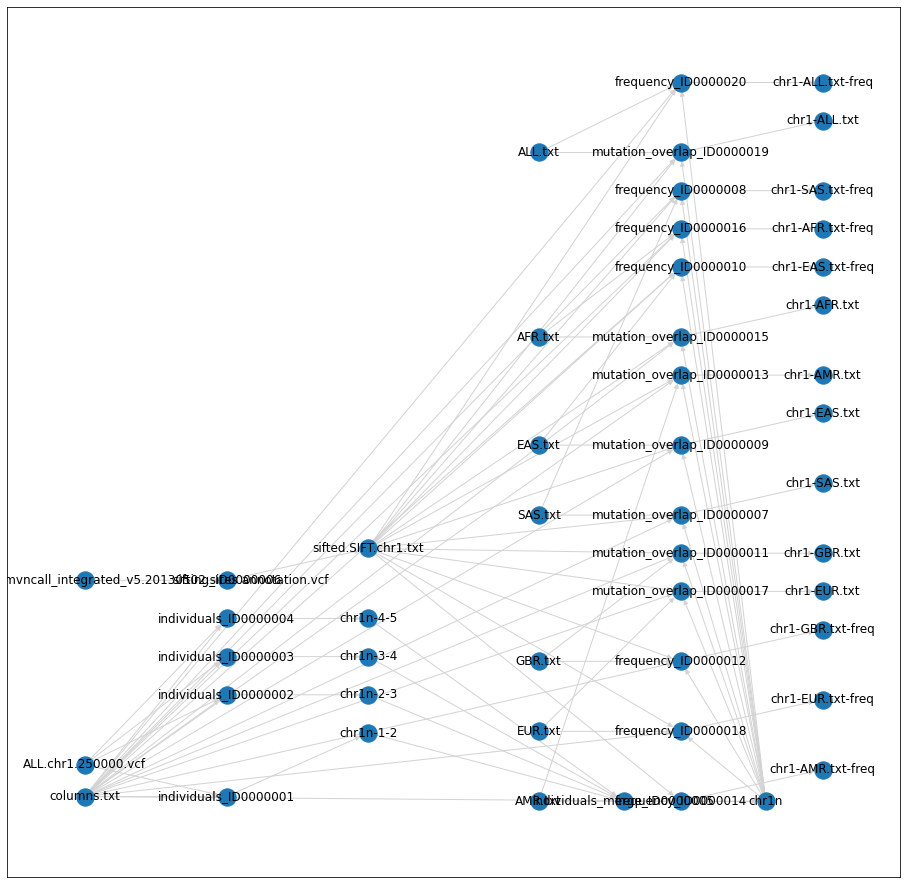

In [4]:
import matplotlib.pyplot as plt

plt.figure(3,figsize=(16,16)) 
colors = ['rgb(204,204,204)' for u,v in G_raw.edges()]
pos = nx.get_node_attributes(G_raw,'pos')
nx.draw_networkx(G_raw, labels=labels, pos=pos, edge_color='lightgrey', style='-')
plt.show()

In [5]:
G = dflg_caterpillar.caterpillars(G_raw)

In [6]:
def get_unique_position(pos_dict):
    check = {}
    for k, p in pos_dict.items():
        if p not in check:
            check[p] = {'last_x': [p[0]]}
        else:
            last_x = check[p]['last_x'][-1]
            pos_dict[k] = (last_x + 1, p[1])
            check[p]['last_x'].append(last_x + 1)
            
def get_pos_(G):
    pos = {}
    space = 1
    x = 1
    y = 1
    last_y = 1
    for u, v in G.edges:
        if u in pos:
            x, y = pos[u]
        else:
            y_add = 0
            if v in pos:
                next_x, next_y = pos[v]
                u_attr, v_attr = G.nodes[u], G.nodes[v]
                #print(G.nodes[u], G.nodes[v])
                y_add = (u_attr['ct_level'] - v_attr['ct_level']) * space
                pos[u] = next_x + space , next_y + y_add
            else:
                new_y = last_y - space
                pos[u] = x, new_y
                y = new_y
        if v in pos:
            x, y = pos[v]
        else:
            pos[v] = (pos[u][0], pos[u][1] - space)
            last_y = min(last_y, pos[u][1] - space)
        last_y = min(last_y, y)
    get_unique_position(pos)
    return pos

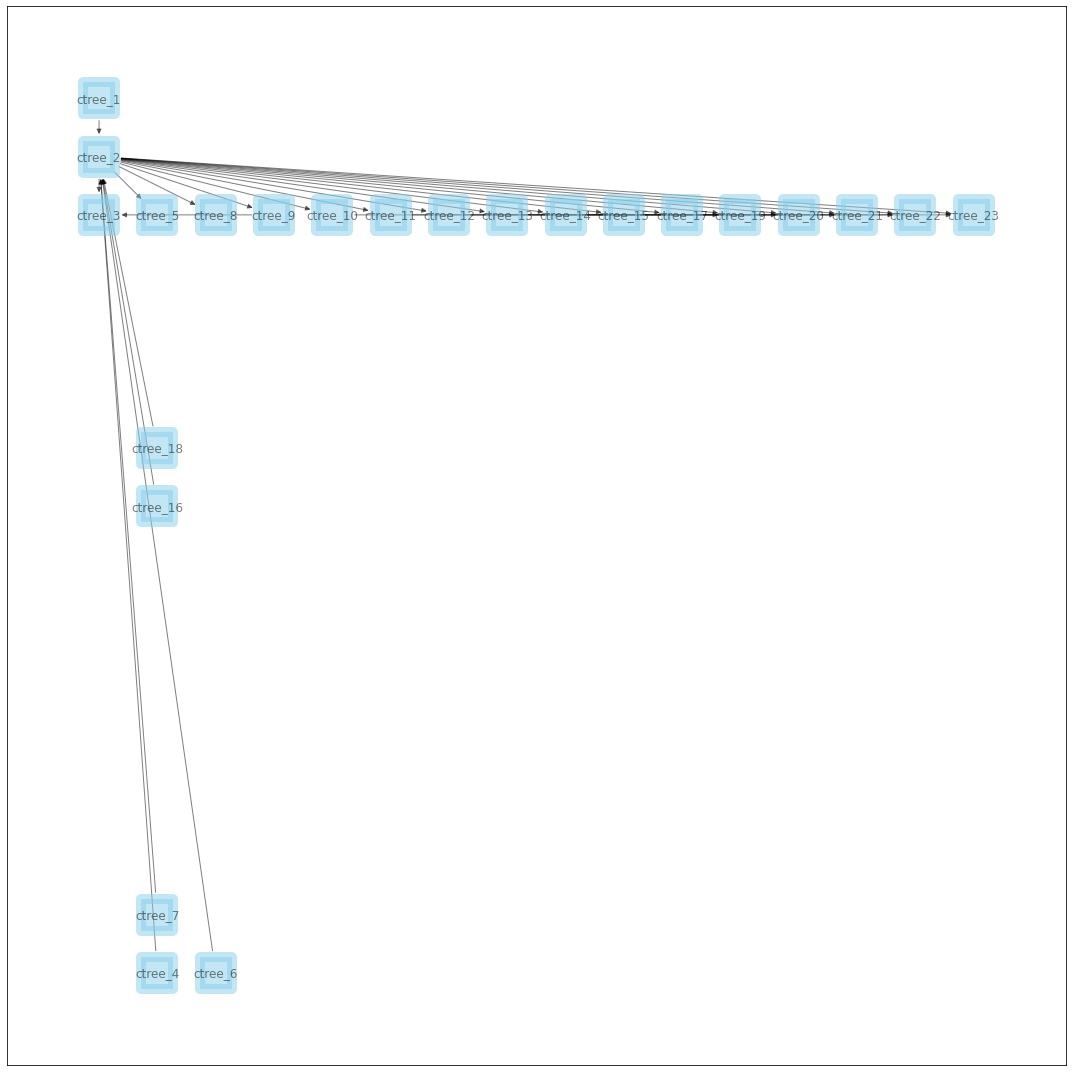

In [7]:
pos_G = get_pos_(G)
labels = {}
idx = 1
for node in G.nodes:
    labels[node] = f'ctree_{idx}'
    idx += 1
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw_networkx(G, pos = pos_G, labels=labels, with_labels=True, ax=ax, node_size=1000, node_color="skyblue",
                 node_shape="s", alpha=0.5, linewidths=10)
fig.tight_layout()
plt.show()    

In [8]:
import random
import numpy as np
from IPython.display import display

default_resource_set = dflg_caterpillar.default_resource_set

def resource_assignment(G, current_queue, res_df=None):
    return bfs_level_sync(G, current_queue)

def bfs_level_sync(G, current_queue):
    while current_queue:
        task_assigned_all = []
        for ct_node in current_queue:
            #print("="*80)
            #print(ct_node)
            #print("="*80)
            required_resources = dflg_caterpillar.resource_required_for_caterpillar(ct_node)
            #print(required_resources)
            # todo 
            # delete
            if required_resources['cpu'] < 1:
                continue
            res_df = get_resource_pool()
            #print(res_df)
            res_avail = request_resource_func(res_df, required_resources)
            #print(res_avail)
            #break
            if len(res_avail) > 0:
                res_df_updated = update_resource_pool(res_df, 'acquisition', res_avail)
                # task assignment
                task_assigned = spawn_ct_tasks(ct_node, res_avail)
                task_assigned_all += task_assigned
                header = "compute_nodename, task_nodename, execution_time (s)"
                #print(header + \
                #      '-' * len(header))
                #print(task_assigned)
                #print(res_df_updated)
                res_df_updated = update_resource_pool(res_df, 'release', res_avail)
                #print(res_df_updated)
            #break
        tmp = pd.DataFrame(task_assigned_all, columns=['compute node', 'task node', 'execution time in second'])
        return tmp
        break

def rand_resource_node(G, resource_grp = default_resource_set):
    resource_res = {}
    for ctree in dflg_caterpillar.task_nodes(G):#G.nodes:
        resource_tmp = {k: 0 for k, v in resource_grp.items()}
        for k, v in resource_grp.items():
            resource_tmp[k] = random.randint(1, int(v))
        resource_res[ctree] = resource_tmp
    nx.set_node_attributes(G, resource_res)
    return G
        
def rand_resource_edge(G, resource_grp = default_resource_set):
    resource_res = {}
    for ctree in G.edges:
        resource_tmp = {k: 0 for k, v in resource_grp.items()}
        for k, v in resource_grp.items():
            resource_tmp[k] = random.randint(1, int(v))
            if 'ntype' in G.nodes[ctree[1]]:
                if k == "data_rate_write":
                    resource_tmp[k] = None
            else:
                if k == "data_rate_read":
                    resource_tmp[k] = None

            #if 'data_rate_write' k
        resource_res[ctree] = resource_tmp
    nx.set_edge_attributes(G, resource_res)
    return G

def rand_exec_time(G, exec_time_grp = {'exec_time_list': [60, 61, 62, 63, 64], #second, 
                                       'upper_bound': 2, # addition,
                                       'lower_bound': 1 # deduction
                                      }):
    time_res = {}
    for ct_node in G.nodes:
        time_tmp = {}
        for k, v in exec_time_grp.items():
            if isinstance(v, list):
                min_v = min(v)
                max_v = max(v)
                len_v = len(v)
                rnd_list = [random.randint(int(min_v), int(max_v)) for x in range(len_v)]
                time_tmp[k] = rnd_list
            else:
                time_tmp[k] = random.randint(1, int(v))
        #estimate = np.mean(time_tmp['exec_time_list']) + time_tmp['upper_bound']
        estimate = get_expected_exec_time(time_tmp)
        time_res[ct_node] = {'estimated_in_second':estimate}
        
    nx.set_node_attributes(G, time_res)
    return G

def get_expected_exec_time(task_attr):
    median = np.median(task_attr['exec_time_list'])
    upper_b = task_attr['upper_bound']
    return median + upper_b
    
def spawn_ct_tasks(ct_node, rdf):
    res = []
    rdf_ = rdf.copy()
    row_cnt = len(rdf_)
    i = 0
    #for task_node, task_attr in ct_node.nodes(data=True):
    for task_node in dflg_caterpillar.task_nodes(ct_node):
        task_attr = ct_node.nodes[task_node]
        rdf__ = rdf_
        for k, v in task_attr.items():
            if k in rdf_:
                rdf__ = rdf__.loc[rdf_[k] >= v]
        if len(rdf__) > 0:
            rdata = rdf__.iloc[0]
            resource_nodename = rdata.name
            # TODO 
            # Check
            exec_time = task_attr['estimated_in_second']#get_expected_exec_time(task_attr)
            task_scheduled = (resource_nodename, task_node, exec_time)
            for k, v in rdata.items():
                rdf__.loc[rdata.name][k] -= rdata[k]
            res.append(task_scheduled)
            i += 1
    return res

def get_resource_pool():
    return res_df

def update_resource_pool(df, rtype, rdf):
    for i in range(len(rdf)):
        rdata = rdf.iloc[i]
        if rtype == 'acquisition':
            for k, v in rdata.items():
                df.loc[rdata.name][k] -= rdata[k]
        elif rtype == 'release':
            for k, v in rdata.items():
                df.loc[rdata.name][k] += rdata[k]
    return df

def request_resource_func(df, rgroup):
    """
    Arguments:
        rgroup (dict): required resources
    Returns:
        res (DataFrame): available resource (row)
    """
    res = df
    #print(rgroup)
    for resource_element in res.columns.to_list():
        v = rgroup[resource_element]
        res = res.loc[df[resource_element] >= v]
        #print(res, resource_element, v)
    #print("#", res)
    return res#res.iloc[0]


def slurm_script(df):
    res = []
    for x in df.iterrows():
        try:
            cpus = tasks[x[1]['task node']]['cpu']
        except:
            continue
        cmd = 'srun --nodelist={} --cpus-per-task={} python {}'.format(x[1]['compute node'], cpus, x[1]['task node'])
        res.append(cmd)
    return res

In [9]:
current_queue = dflg_caterpillar.get_roots(G)

for x in current_queue:
    data_resource_set = default_resource_set.copy()
    del(data_resource_set['cpu'])
    rand_resource_node(x, {'cpu': default_resource_set['cpu']})
    rand_resource_edge(x, data_resource_set)    
    rand_exec_time(x)

In [10]:
import pandas as pd

first_caterpillar = current_queue[0]
tasks = {}
for task_node in dflg_caterpillar.task_nodes(first_caterpillar):
    tasks[task_node] = first_caterpillar.nodes[task_node]
#tasks = dict(first_caterpillar.nodes(data=True))#
pd.DataFrame.from_dict(tasks, orient='index')

,ntype,cpu,estimated_in_second
sifting_ID0000006,task,27,63.0
mutation_overlap_ID0000013,task,30,63.0
mutation_overlap_ID0000019,task,16,63.0
frequency_ID0000010,task,23,64.0
frequency_ID0000012,task,27,62.0
frequency_ID0000008,task,29,64.0
mutation_overlap_ID0000007,task,9,64.0
mutation_overlap_ID0000015,task,26,63.0
mutation_overlap_ID0000011,task,1,62.0
frequency_ID0000020,task,23,64.0


In [11]:
data = {}
for u, v, attr in first_caterpillar.edges(data=True):
    data[(u,v)] = attr
pd.DataFrame.from_dict(data, orient='index')

value  \
ALL.chr1.phase3_shapeit2_mvncall_integrated_v5.... sifting_ID0000006               1   
sifting_ID0000006                                  sifted.SIFT.chr1.txt            1   
sifted.SIFT.chr1.txt                               mutation_overlap_ID0000013      1   
                                                   mutation_overlap_ID0000019      1   
                                                   frequency_ID0000010             1   
                                                   frequency_ID0000012             1   
                                                   frequency_ID0000008             1   
                                                   mutation_overlap_ID0000007      1   
                                                   mutation_overlap_ID0000015      1   
                                                   mutation_overlap_ID0000011      1   
                                                   frequency_ID0000020             1   
                                                   mutation_overlap_ID0000009      1   
                                                   frequency_ID0000016             1   
                                                   mutation_overlap_ID0000017      1   
                                                   frequency_ID0000018             1   
EUR.txt                                            frequency_ID0000018             1   
frequency_ID0000018                                chr1-EUR.txt-freq.tar.gz        1   

                                                                               data_rate_write  \
ALL.chr1.phase3_shapeit2_mvncall_integrated_v5.... sifting_ID0000006                       NaN   
sifting_ID0000006                                  sifted.SIFT.chr1.txt                  266.0   
sifted.SIFT.chr1.txt                               mutation_overlap_ID0000013              NaN   
                                                   mutation_overlap_ID0000019              NaN   
                                                   frequency_ID0000010                     NaN   
                                                   frequency_ID0000012                     NaN   
                                                   frequency_ID0000008                     NaN   
                                                   mutation_overlap_ID0000007              NaN   
                                                   mutation_overlap_ID0000015              NaN   
                                                   mutation_overlap_ID0000011              NaN   
                                                   frequency_ID0000020                     NaN   
                                                   mutation_overlap_ID0000009              NaN   
                                                   frequency_ID0000016                     NaN   
                                                   mutation_overlap_ID0000017              NaN   
                                                   frequency_ID0000018                     NaN   
EUR.txt                                            frequency_ID0000018                     NaN   
frequency_ID0000018                                chr1-EUR.txt-freq.tar.gz              127.0   

                                                                               data_rate_read  \
ALL.chr1.phase3_shapeit2_mvncall_integrated_v5.... sifting_ID0000006                   1729.0   
sifting_ID0000006                                  sifted.SIFT.chr1.txt                   NaN   
sifted.SIFT.chr1.txt                               mutation_overlap_ID0000013          2365.0   
                                                   mutation_overlap_ID0000019           502.0   
                                                   frequency_ID0000010                   55.0   
                                                   frequency_ID0000012                 1958.0   
                                                  

In [12]:
ctree_resources = {}
idx = 0
for ctree in current_queue:
    try:
        required_resources = dflg_caterpillar.resource_required_for_caterpillar(ctree)
        # TODO
        # remove this exception
        if required_resources['cpu'] == 0:
            continue
        ctree_resources[f'current_queue_{idx} (caterpillar segment #{idx+1})'] = required_resources
        idx += 1
    except:
        print(ctree, idx)
        pass
        #TODO
        #ctree is possible to only have data vertices, fix this
df_ctree_resources = pd.DataFrame.from_dict(ctree_resources, orient='index')
df_ctree_resources

,cpu,max_rate_r,max_rate_w,volume,estimated_in_second
current_queue_0 (caterpillar segment #1),32,2995,266,9734449,888.0
current_queue_1 (caterpillar segment #2),27,2524,80,1917098,192.0
current_queue_2 (caterpillar segment #3),10,2627,234,321122,65.0


In [13]:
res_dict = {'compute_node_1': [32, 300, 2000, 12000000, 3600], 
            'compute_node_2': [32, 400, 3000, 45000000, 3600],
            'compute_node_3': [32, 200, 3000, 54000000, 3600]}
# TODO
# allocated time length to each compute row? accounting purpose for used and allocated
res_df = pd.DataFrame.from_dict(res_dict, orient='index',
                       columns=['cpu', 'max_rate_w', 'max_rate_r', 'volume', 'allocated time'])
res_capacity = res_df.copy()
res_df

,cpu,max_rate_w,max_rate_r,volume,allocated time
compute_node_1,32,300,2000,12000000,3600
compute_node_2,32,400,3000,45000000,3600
compute_node_3,32,200,3000,54000000,3600


In [14]:
del(res_df['allocated time'])

In [15]:
task_node_compute_mapping = resource_assignment(G, current_queue, res_df)
task_node_compute_mapping

,compute node,task node,execution time in second
0,compute_node_2,sifting_ID0000006,63.0
1,compute_node_2,mutation_overlap_ID0000013,63.0
2,compute_node_2,mutation_overlap_ID0000019,63.0
3,compute_node_2,frequency_ID0000010,64.0
4,compute_node_2,frequency_ID0000012,62.0
5,compute_node_2,frequency_ID0000008,64.0
6,compute_node_2,mutation_overlap_ID0000007,64.0
7,compute_node_2,mutation_overlap_ID0000015,63.0
8,compute_node_2,mutation_overlap_ID0000011,62.0
9,compute_node_2,frequency_ID0000020,64.0


In [16]:
srun_commands = slurm_script(task_node_compute_mapping)
srun_commands

['srun --nodelist=compute_node_2 --cpus-per-task=27 python sifting_ID0000006',
 'srun --nodelist=compute_node_2 --cpus-per-task=30 python mutation_overlap_ID0000013',
 'srun --nodelist=compute_node_2 --cpus-per-task=16 python mutation_overlap_ID0000019',
 'srun --nodelist=compute_node_2 --cpus-per-task=23 python frequency_ID0000010',
 'srun --nodelist=compute_node_2 --cpus-per-task=27 python frequency_ID0000012',
 'srun --nodelist=compute_node_2 --cpus-per-task=29 python frequency_ID0000008',
 'srun --nodelist=compute_node_2 --cpus-per-task=9 python mutation_overlap_ID0000007',
 'srun --nodelist=compute_node_2 --cpus-per-task=26 python mutation_overlap_ID0000015',
 'srun --nodelist=compute_node_2 --cpus-per-task=1 python mutation_overlap_ID0000011',
 'srun --nodelist=compute_node_2 --cpus-per-task=23 python frequency_ID0000020',
 'srun --nodelist=compute_node_2 --cpus-per-task=32 python mutation_overlap_ID0000009',
 'srun --nodelist=compute_node_2 --cpus-per-task=7 python frequency_ID0